In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import *
from src.models import * 
from src.concept_vectors import *
from src.create_vectors import *
import csv
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import seaborn as sns
import json 
import pickle 

## Impact of Flip Percentage

In [6]:
dataset = CUB_Dataset()
attributes = dataset.get_attributes()
load_label_vectors_simple(attributes[0],dataset,"")

array([[0, 0, 0, ..., 0, 0, 0]])

In [15]:
def create_load_label_vectors_flipped(flip_percentage):
    def load_label_vectors_simple_flipped(attribute,dataset,suffix,seed=-1):
        loaded_vectors = load_label_vectors_simple(attribute,dataset,"",seed=seed)
        for i in range(len(loaded_vectors)):
            for j in range(len(loaded_vectors[i])):
                if np.random.random() < flip_percentage:
                    loaded_vectors[i,j] = 1-loaded_vectors[i,j]
        return loaded_vectors 
    return load_label_vectors_simple_flipped

In [29]:
results_by_flip_percentage = {}
for flip_percent in [0.01,0.05,0.1,0.25,0.5]:
    embedding_method = create_load_label_vectors_flipped(flip_percent)
    baseline_embeddings = [flat_distance_to_square(get_concept_distances
                                                    (load_label_vectors_simple,dataset,"",attributes,seed)) for seed in [42,43,44]]

    robust_hierarchies = [flat_distance_to_square(get_concept_distances(embedding_method,dataset,"",attributes,seed)) for seed in [42,43,44]]
    
    print("Created robust hierarchies for {}".format(flip_percent))
    distance_list = []
    for h1,h2 in zip(baseline_embeddings,robust_hierarchies):
        k = 3
        if dataset.experiment_name == 'mnist':
            k = 1
        distance_list.append(embedding_distance(h1,h2,k=k))
    results_by_flip_percentage[flip_percent] = (np.mean(distance_list),np.std(distance_list))

Created robust hierarchies for 0.01
Created robust hierarchies for 0.05
Created robust hierarchies for 0.1
Created robust hierarchies for 0.25
Created robust hierarchies for 0.5


In [30]:
results_by_flip_percentage

{0.01: (0.03968253968253969, 0.005611958580845648),
 0.05: (0.07837301587301586, 0.003711961693228153),
 0.1: (0.14384920634920637, 0.007423923386456256),
 0.25: (0.34722222222222215, 0.014847846772912503),
 0.5: (0.9771825396825397, 0.014647641924834713)}

In [36]:
json.dump(results_by_flip_percentage,open("results/evaluation/flip_ablation/label.json","w"))

In [38]:
load_concept2vec_vectors_simple(attributes[0],dataset,"",seed=42)

array([[-0.08862728, -0.22278228, -0.33395338,  0.3019868 , -0.01222411,
         0.29873982,  0.35323834,  0.1366382 , -0.25656658,  0.324455  ,
         0.17890984, -0.32997307, -0.01974672, -0.2481588 , -0.2735666 ,
         0.2445152 ,  0.15376762,  0.3406197 ,  0.02418177, -0.03433285,
         0.26493436, -0.0081104 ,  0.28707227, -0.31152803, -0.20898055,
        -0.19636793, -0.23137163,  0.26689827,  0.21054439,  0.27037305,
         0.14287092, -0.04401413]], dtype=float32)

In [52]:
create_concept2vec(dataset,"",seed=42,
                             embedding_size=32,num_epochs=5,dataset_size=1000,initial_embedding=None,write_data=False,flip_percentage=0.5).shape

500/500 [==============================] - 0s 699us/step - loss: 0.6932


(112, 32)

In [67]:
results_by_flip_percentage = {}
for flip_percent in [0.01,0.05,0.1,0.25,0.5]:
    baseline_embeddings = [flat_distance_to_square(get_concept_distances
                                                    (load_concept2vec_vectors_simple,dataset,"",attributes,seed)) for seed in [42,43,44]]

    robust_hierarchies = []

    for seed in [42,43,44]:
        all_vectors = create_concept2vec(dataset,"",seed=seed,
                        embedding_size=32,num_epochs=5,dataset_size=1000,initial_embedding=None,write_data=False,flip_percentage=flip_percent)
        
        def load_concept2vec_vectors_simple_flipped(attribute,dataset,suffix,seed=-1):
            loaded_vectors = [all_vectors[dataset.get_attributes().index(attribute)]]
            return loaded_vectors
        embedding_method = load_concept2vec_vectors_simple_flipped


        robust_hierarchies.append(flat_distance_to_square(get_concept_distances(embedding_method,dataset,"",attributes,seed)))
    
    print("Created robust hierarchies for {}".format(flip_percent))
    distance_list = []
    for h1,h2 in zip(baseline_embeddings,robust_hierarchies):
        k = 3
        if dataset.experiment_name == 'mnist':
            k = 1
        distance_list.append(embedding_distance(h1,h2,k=k))
    results_by_flip_percentage[flip_percent] = (np.mean(distance_list),np.std(distance_list))

500/500 [==============================] - 0s 693us/step - loss: 0.5711
Created robust hierarchies for 0.01
500/500 [==============================] - 0s 701us/step - loss: 0.6119
Created robust hierarchies for 0.05
500/500 [==============================] - 0s 712us/step - loss: 0.6444
Created robust hierarchies for 0.1
500/500 [==============================] - 0s 705us/step - loss: 0.6789
Created robust hierarchies for 0.25
500/500 [==============================] - 0s 710us/step - loss: 0.6930
Created robust hierarchies for 0.5


In [68]:
results_by_flip_percentage

{0.01: (0.7043650793650794, 0.02335040138083299),
 0.05: (0.8065476190476191, 0.031777018607236064),
 0.1: (0.9146825396825397, 0.018238865387748236),
 0.25: (0.9533730158730158, 0.005611958580845648),
 0.5: (0.9632936507936508, 0.006115490082310471)}

In [70]:
json.dump(results_by_flip_percentage,open("results/evaluation/flip_ablation/concept2vec.json","w"))

## CBM + Hierarchy

In [ ]:
f = open("results/evaluation/cub_noise_ablation.txt").read()
print(f)
# Values are evalautions of the image robustness

flip_prob_0.01: (0.0, 0.0)
flip_prob_0.05: (0.0, 0.0)
flip_prob_0.1: (0.0, 0.0)
noise_0.1: (0.5386904761904762, 0.0)



### Compare Models

In [ ]:
f = open("results/evaluation/cub_model_comparison.txt").read()
print(f)
# Distances between models; lower is closer

resnet50: (0.7519841269841269, 0.10212955167961259)
inceptionv3: (0.01091269841269841, 0.015432886097325441)



In [ ]:
dataset = CUB_Dataset()
attributes = dataset.get_attributes()

In [ ]:
def get_shapley_model(model_name):
    def get_vectors(attribute,dataset,suffix,seed=-1):
        return np.load(open("results/shapley/{}_model_{}/{}/{}.npy".format(dataset.experiment_name+suffix,model_name,seed,attribute),"rb"),allow_pickle=True)

    return get_vectors

In [ ]:
cub_hierarchy_vgg16 = create_hierarchy(create_ward_hierarchy,load_shapley_vectors_simple,dataset,'',attributes,43)
print(cub_hierarchy_vgg16)

                          ---- has_upper_tail_color::buff
                     ----|
                          ---- has_under_tail_color::buff

                ----|
                               ---- has_upperparts_color::buff
                          ----|
                                    ---- has_wing_color::buff
                               ----|
                                    ---- has_back_color::buff


                     ----|
                               ---- has_nape_color::buff
                          ----|
                               ---- has_primary_color::buff



           ----|
                     ---- has_throat_color::buff
                ----|
                          ---- has_breast_color::buff
                     ----|
                               ---- has_underparts_color::buff
                          ----|
                               ---- has_belly_color::buff




      ----|
                     ---- has_belly_color::brown
          

In [ ]:
cub_hierarchy_resnet50 = create_hierarchy(create_ward_hierarchy,get_shapley_model("resnet50"),dataset,'',attributes,43)
print(cub_hierarchy_resnet50)

                ---- has_size::medium_(9_-_16_in)
           ----|
                ---- has_shape::duck-like

      ----|
                          ---- has_bill_shape::dagger
                     ----|
                          ---- has_crown_color::white

                ----|
                          ---- has_bill_length::about_the_same_as_head
                     ----|
                          ---- has_primary_color::black


           ----|
                          ---- has_nape_color::white
                     ----|
                               ---- has_upperparts_color::white
                          ----|
                               ---- has_back_color::white


                ----|
                               ---- has_bill_shape::hooked_seabird
                          ----|
                               ---- has_under_tail_color::white

                     ----|
                               ---- has_upper_tail_color::white
                          ----|
  

In [ ]:
cub_hierarchy_inceptionv3 = create_hierarchy(create_ward_hierarchy,get_shapley_model("inceptionv3"),dataset,'',attributes,43)
print(cub_hierarchy_inceptionv3)

                          ---- has_upper_tail_color::buff
                     ----|
                          ---- has_under_tail_color::buff

                ----|
                               ---- has_upperparts_color::buff
                          ----|
                                    ---- has_wing_color::buff
                               ----|
                                    ---- has_back_color::buff


                     ----|
                               ---- has_nape_color::buff
                          ----|
                               ---- has_primary_color::buff



           ----|
                     ---- has_throat_color::buff
                ----|
                          ---- has_breast_color::buff
                     ----|
                               ---- has_underparts_color::buff
                          ----|
                               ---- has_belly_color::buff




      ----|
                     ---- has_belly_color::brown
          

### CBM + Hierarchy Ablation

In [ ]:
with open('results/knn/wandb_data.csv', 'r') as file:
    csv_reader = csv.reader(file)
    headers = next(csv_reader)
    
    data = []
    
    for row in csv_reader:
        row_dict = {}
        for i in range(len(headers)):
            row_dict[headers[i]] = row[i]
        
        data.append(row_dict)


In [ ]:
for d in data:
    if 'fixed' in d['Name']:
        d['fixed'] = True
    else:
        d['fixed'] = False
    d['pretrain'] = bool(d['pretrain'])
    d['seed'] = int(d['seed'])
    d['test_acc'] = float(d['test_acc'])

In [ ]:
data[0]

{'Name': 'dsprites mlp fixed 45',
 'State': 'finished',
 'Notes': '-',
 'User': 'navr414',
 'Tags': '',
 'Created': '2023-04-30T13:14:56.000Z',
 'Runtime': '88',
 'Sweep': '',
 'architecture': 'mlp',
 'dataset': 'dsprites',
 'epochs': '10',
 'learning_rate': '0.005',
 'num_clauses': '',
 'pretrain': True,
 'hierarchy_name': 'shapley',
 'seed': 45,
 'epoch': '9',
 'train_acc': '0.3984000086784363',
 'train_loss': '1.5188103914260864',
 'trainer/global_step': '789',
 'val_acc': '0.390666663646698',
 'val_loss': '1.5175566673278809',
 'loss': '1.9835715293884275',
 'test_acc': 0.4000000059604645,
 'test_auc': '',
 'fixed': True}

#### CUB

MLP: 0.6796666666666668 0.0016996731711975965
MLP Fixed: 0.6813333333333333 0.0018856180831641283


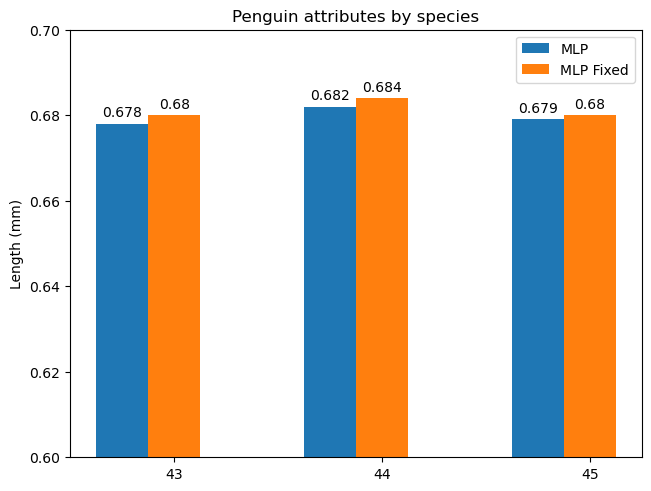

In [ ]:
seeds = [43, 44, 45]
fixed_false_acc = []
fixed_true_acc = []
dataset_name = 'cub'

for d in sorted(data,key=lambda k: k['seed']):
    if int(d['seed']) in seeds and d['dataset'] == dataset_name:
        if d['architecture'] == 'mlp' and d['fixed'] == False:
            fixed_false_acc.append(float(d['test_acc']))
        elif d['architecture'] == 'mlp' and d['fixed'] == True:
            fixed_true_acc.append(float(d['test_acc']))

fixed_false_acc = [round(i,3) for i in fixed_false_acc]
fixed_true_acc = [round(i,3) for i in fixed_true_acc]
            
test_acc = {
    'MLP': fixed_false_acc,
    'MLP Fixed': fixed_true_acc,
}

x = np.arange(len(seeds))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

print('MLP: {} {}'.format(np.mean(fixed_false_acc),np.std(fixed_false_acc)))
print('MLP Fixed: {} {}'.format(np.mean(fixed_true_acc),np.std(fixed_true_acc)))

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, [str(i) for i in seeds])
plt.legend()
ax.set_ylim(0.6,0.7)

plt.show()


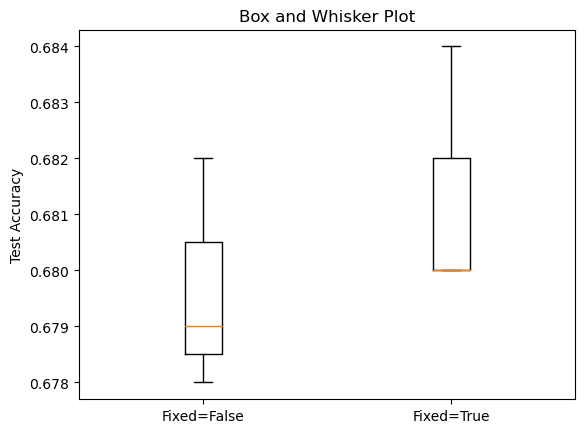

In [ ]:
box_whisker_data = [fixed_false_acc, fixed_true_acc]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title('Box and Whisker Plot')

# Create the box and whisker plot
ax.boxplot(box_whisker_data)

# Set the x-tick labels
ax.set_xticklabels(['Fixed=False', 'Fixed=True'])

# Set the y-axis label
ax.set_ylabel('Test Accuracy')

# Show the plot
plt.show()


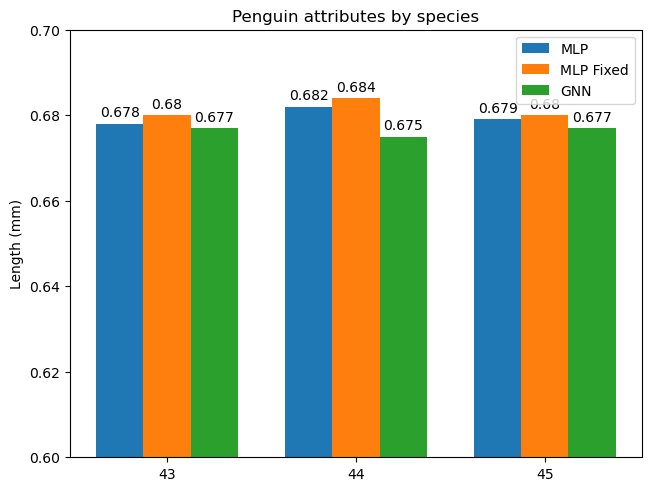

In [ ]:
seeds = [43, 44, 45]
fixed_false_acc = []
fixed_true_acc = []
fixed_gnn_simple = []
dataset_name = 'cub'

for d in sorted(data,key=lambda k: k['seed']):
    if int(d['seed']) in seeds and d['dataset'] == dataset_name:
        if d['architecture'] == 'mlp' and d['fixed'] == False:
            fixed_false_acc.append(float(d['test_acc']))
        elif d['architecture'] == 'mlp' and d['fixed'] == True:
            fixed_true_acc.append(float(d['test_acc']))
        elif d['architecture'] == 'gnn_basic' and d['hierarchy_name'] == 'shapley':
            fixed_gnn_simple.append(float(d['test_acc']))

fixed_false_acc = [round(i,3) for i in fixed_false_acc]
fixed_true_acc = [round(i,3) for i in fixed_true_acc]
fixed_gnn_simple = [round(i,3) for i in fixed_gnn_simple]
            
test_acc = {
    'MLP': fixed_false_acc,
    'MLP Fixed': fixed_true_acc,
    'GNN': fixed_gnn_simple
}

x = np.arange(len(seeds))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0



fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, [str(i) for i in seeds])
plt.legend()
ax.set_ylim(0.6,0.7)

plt.show()


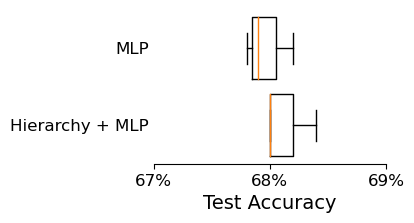

In [ ]:
box_whisker_data = [fixed_true_acc, fixed_false_acc]

with plt.style.context("tableau-colorblind10"):

    def percentage(x, pos):
        return '{:.0%}'.format(x)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(3,2))

    # Create the box and whisker plot horizontally
    ax.boxplot(box_whisker_data, vert=False,widths=0.8)

    # Set the y-tick labels
    ax.set_yticklabels(['Hierarchy + MLP', 'MLP'])

    formatter = FuncFormatter(percentage)
    ax.xaxis.set_major_formatter(formatter)

    # Set the x-axis label
    ax.set_xlabel('Test Accuracy',fontsize=14)
    plt.xlim([0.67,0.69])
    plt.xticks([0.67,0.68,0.69],fontsize=12)
    plt.yticks(fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)

    plt.savefig('scripts/Figures/box_plot_cbm.pdf', dpi=300, bbox_inches='tight')    
    # Show the plot
    plt.show()


#### DSprites

MLP: 0.20000000000000004 2.7755575615628914e-17
MLP Fixed: 0.4053333333333334 0.012814921857827377


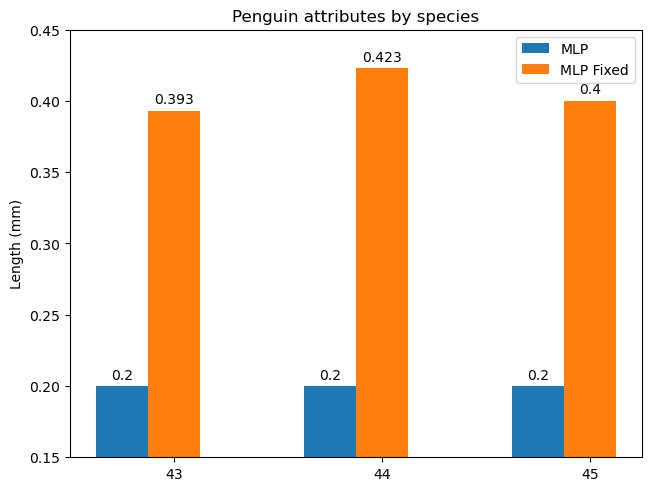

In [ ]:
seeds = [43, 44, 45]
fixed_false_acc = []
fixed_true_acc = []
dataset_name = 'dsprites'

for d in sorted(data,key=lambda k: k['seed']):
    if int(d['seed']) in seeds and d['dataset'] == dataset_name:
        if d['architecture'] == 'mlp' and d['fixed'] == False:
            fixed_false_acc.append(float(d['test_acc']))
        elif d['architecture'] == 'mlp' and d['fixed'] == True:
            fixed_true_acc.append(float(d['test_acc']))

fixed_false_acc = [round(i,3) for i in fixed_false_acc]
fixed_true_acc = [round(i,3) for i in fixed_true_acc]
            
test_acc = {
    'MLP': fixed_false_acc,
    'MLP Fixed': fixed_true_acc,
}

print('MLP: {} {}'.format(np.mean(fixed_false_acc),np.std(fixed_false_acc)))
print('MLP Fixed: {} {}'.format(np.mean(fixed_true_acc),np.std(fixed_true_acc)))

x = np.arange(len(seeds))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0



fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, [str(i) for i in seeds])
plt.legend()
ax.set_ylim(0.15,0.45)

plt.show()


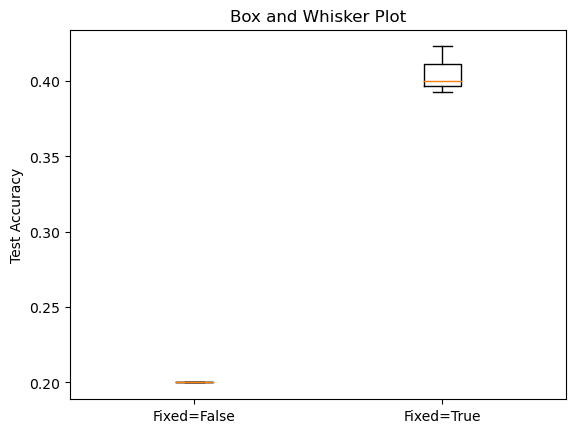

In [ ]:
box_whisker_data = [fixed_false_acc, fixed_true_acc]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title('Box and Whisker Plot')

# Create the box and whisker plot
ax.boxplot(box_whisker_data)

# Set the x-tick labels
ax.set_xticklabels(['Fixed=False', 'Fixed=True'])

# Set the y-axis label
ax.set_ylabel('Test Accuracy')

# Show the plot
plt.show()

#### Chexpert

MLP: 0.8413333333333334 0.0023570226039551605
MLP Fixed: 0.8393333333333333 0.0009428090415820641


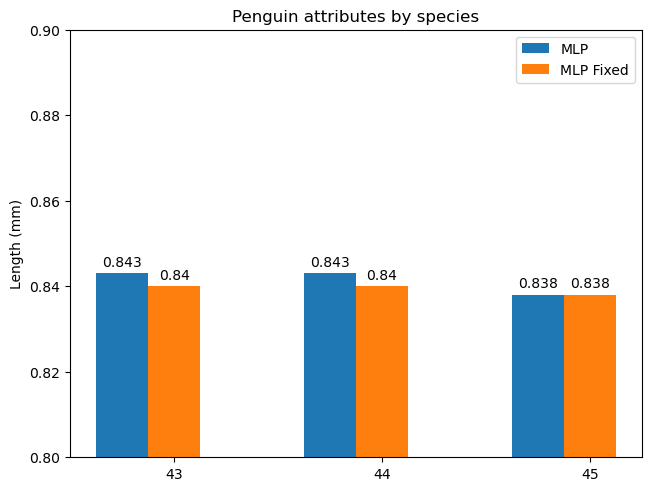

In [ ]:
seeds = [43, 44, 45]
fixed_false_acc = []
fixed_true_acc = []
dataset_name = 'chexpert'

for d in sorted(data,key=lambda k: k['seed']):
    if int(d['seed']) in seeds and d['dataset'] == dataset_name:
        if d['architecture'] == 'mlp' and d['fixed'] == False:
            fixed_false_acc.append(float(d['test_acc']))
        elif d['architecture'] == 'mlp' and d['fixed'] == True:
            fixed_true_acc.append(float(d['test_acc']))

fixed_false_acc = [round(i,3) for i in fixed_false_acc]
fixed_true_acc = [round(i,3) for i in fixed_true_acc]
            
test_acc = {
    'MLP': fixed_false_acc,
    'MLP Fixed': fixed_true_acc,
}

x = np.arange(len(seeds))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

print('MLP: {} {}'.format(np.mean(fixed_false_acc),np.std(fixed_false_acc)))
print('MLP Fixed: {} {}'.format(np.mean(fixed_true_acc),np.std(fixed_true_acc)))

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, [str(i) for i in seeds])
plt.legend()
ax.set_ylim(0.8,0.9)

plt.show()


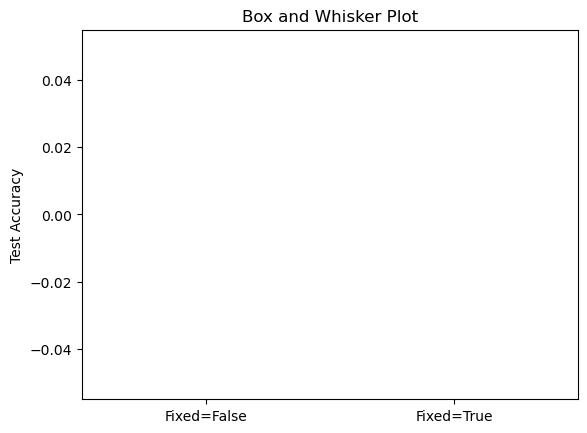

In [ ]:
box_whisker_data = [fixed_false_acc, fixed_true_acc]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title('Box and Whisker Plot')

# Create the box and whisker plot
ax.boxplot(box_whisker_data)

# Set the x-tick labels
ax.set_xticklabels(['Fixed=False', 'Fixed=True'])

# Set the y-axis label
ax.set_ylabel('Test Accuracy')

# Show the plot
plt.show()

## KNN + Hierarchy

In [ ]:
datasets = ['cub','chexpert','dsprites']

In [ ]:
for d in datasets:
    print("== {} ==".format(d))
    print(open("results/knn/{}.txt".format(d)).read())

== cub ==
logit_acc: (0.9770995919218396, 0.9445504412115431, 0.9468030351595247)
fix_acc: (0.9802420916239724, 0.9468608394943954, 0.9488171260910301)
logit_knn: 0.6731101139109423
round_knn: 0.6280635139799793
predict_knn: 0.6441146013117017
prob_1: 0.6751812219537453
prob_2: 0.6758715913013462
concept_prob: 0.6772523299965482
trimmed: 0.6330686917500863
baseline: 0.6731101139109423, 0.6731101139109423, 0.6731101139109423
concept: 0.676389368312047, 0.6794960303762513, 0.6753538142906454
idx: ???
y_image: 19
baseline_image: 199
concept_image: 19
baseline_images: 3991, 2121, 1246,  503, 2427
concept_images: 4445,  503, 3991, 2121, 2916

== chexpert ==
logit_acc: (0.8890192307692307, 0.8614615384615385, 0.8651538461538462)
fix_acc: (0.8900384615384616, 0.8637692307692307, 0.8647692307692307)
logit_knn: 0.837
round_knn: 0.688
predict_knn: 0.69
prob_1: 0.835
prob_2: 0.839
concept_prob: 0.841
trimmed: 0.668
baseline: 0.837, 0.837, 0.837
concept: 0.828, 0.838, 0.841
idx: 806
y_image: 0
bas

### Comparing to Zhang-Sha Sha

In [ ]:
zhang_distances = json.load(open('results/extra_evaluation/similarity_to_zhang.json','r'))

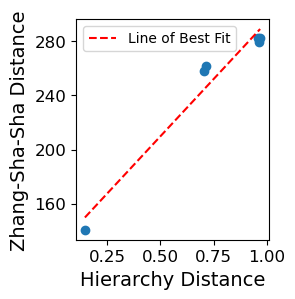

In [ ]:
x_data = [i[0] for i in zhang_distances['cosine']]
y_data = [i[1] for i in zhang_distances['cosine']]

# Fit a polynomial regression line
degree = 1  # Linear regression
coefficients = np.polyfit(x_data, y_data, degree)

# Create a polynomial function from the coefficients
poly_function = np.poly1d(coefficients)

# Generate a range of x values for the line of best fit
x_fit = np.linspace(min(x_data), max(x_data), 100)

# Calculate the corresponding y values using the polynomial function
y_fit = poly_function(x_fit)

# Create the scatter plot
plt.figure(figsize=(3, 3))
plt.xlabel("Hierarchy Distance", fontsize=14)
plt.ylabel("Zhang-Sha-Sha Distance", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([160, 200, 240, 280], fontsize=12)

# Add the scatter points
plt.scatter(x_data, y_data)

# Add the line of best fit
plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Line of Best Fit')

plt.legend()  # Add a legend to the plot

plt.tight_layout()

plt.savefig("figures/zhang_cosine.pdf", dpi=300, bbox_inches='tight')
plt.show()


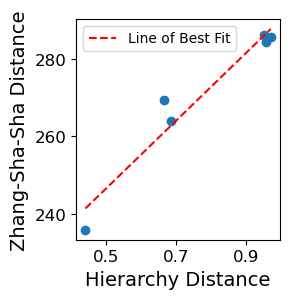

In [ ]:
x_data = [i[0] for i in zhang_distances['euclidean']]
y_data = [i[1] for i in zhang_distances['euclidean']]

# Fit a polynomial regression line
degree = 1  # Linear regression
coefficients = np.polyfit(x_data, y_data, degree)

# Create a polynomial function from the coefficients
poly_function = np.poly1d(coefficients)

# Generate a range of x values for the line of best fit
x_fit = np.linspace(min(x_data), max(x_data), 100)

# Calculate the corresponding y values using the polynomial function
y_fit = poly_function(x_fit)

# Create the scatter plot
plt.figure(figsize=(3, 3))
plt.xlabel("Hierarchy Distance", fontsize=14)
plt.ylabel("Zhang-Sha-Sha Distance", fontsize=14)
plt.xticks([0.5,0.7,0.9],fontsize=12)
plt.yticks([240,260,280], fontsize=12)

# Add the scatter points
plt.scatter(x_data, y_data)

# Add the line of best fit
plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Line of Best Fit')

plt.legend()  # Add a legend to the plot

plt.tight_layout()
plt.savefig("figures/zhang_euclidean.pdf", dpi=300, bbox_inches='tight')
plt.show()
